In [2]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import libpysal as lp
import esda
import numpy as np
import matplotlib.pyplot as plt

# Case Study: *Gini in a bottle: Income Inequality and the Trump Vote*

#### Read in the table and show the first three rows

In [4]:
# %load _solved/solutions/case-trump-vote01.py
pres = gpd.read_file("zip://../data/uspres.zip")
pres.head(3)


,name,state_name,stfips,cofips,fipsno,dem_2008,dem_2012,dem_2016,gini_2015,state,county,fips,geometry
0,Delta,Michigan,26,41,26041,0.532316,0.466327,0.366585,0.4268,26,041,26041,POLYGON ((-86.45813751220703 45.76276779174805...
1,Lipscomb,Texas,48,295,48295,0.124199,0.102322,0.104328,0.4437,48,295,48295,POLYGON ((-100.0068664550781 36.49387741088867...
2,Walker,Alabama,1,127,1127,0.263663,0.232437,0.156339,0.4594,01,127,1127,POLYGON ((-87.41892242431641 33.60782241821289...


#### Set the CRS and reproject it into a suitable projection for mapping the contiguous US

*hint: the epsg code useful here is 5070, for Albers equal area conic*

In [5]:
# %load _solved/solutions/case-trump-vote02.py
pres.crs = {'init':'epsg:4269'}
pres = pres.to_crs(epsg=5070)

#### Plot each year's vote against each other year's vote
In this instance, it also helps to include the line ($y=x$) on each plot, so that it is clearer the directions the aggregate votes moved.   

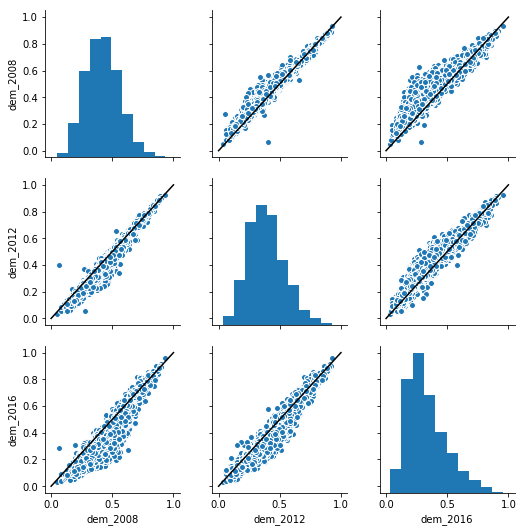

In [6]:
# %load _solved/solutions/case-trump-vote03.py
import seaborn as sns
facets = sns.pairplot(data=pres.filter(like='dem_'))
facets.map_offdiag(lambda *arg, **kw: plt.plot((0,1),(0,1), color='k'))

#### Show the relationship between the dem two-party vote and the Gini coefficient by county.

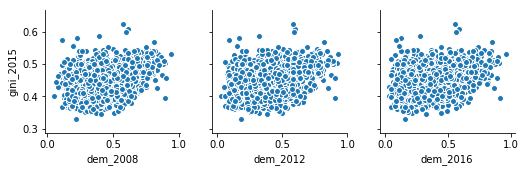

In [7]:
# %load _solved/solutions/case-trump-vote04.py
import seaborn as sns
facets = sns.pairplot(x_vars=pres.filter(like='dem_').columns,
                      y_vars=['gini_2015'], data=pres)

#### Compute the swings (change in vote from year to year)

In [8]:
# %load _solved/solutions/case-trump-vote05.py
pres['swing_2012'] = pres.eval("dem_2012 - dem_2008")
pres['swing_2016'] = pres.eval("dem_2016 - dem_2012")
pres['swing_full'] = pres.eval("dem_2016 - dem_2008")

Negative swing means the Democrat voteshare in 2016 (what Clinton won) is lower than Democrat voteshare in 2008 (what Obama won).
So, counties where swing is negative mean that Obama "outperformed" Clinton. 
Equivalently, these would be counties where McCain (in 2008) "beat" Trump's electoral performance in 2016.

Positive swing in a county means that Clinton (in 2016) outperformed Obama (in 2008), or where Trump (in 2016) did better than McCain (in 2008). 

The national average swing was around -9% from 2008 to 2016. Further, swing does not directly record who "won" the county, only which direction the county "moved."

#### map the swing from 2008 to 2016 alongside the votes in 2008 and 2016:

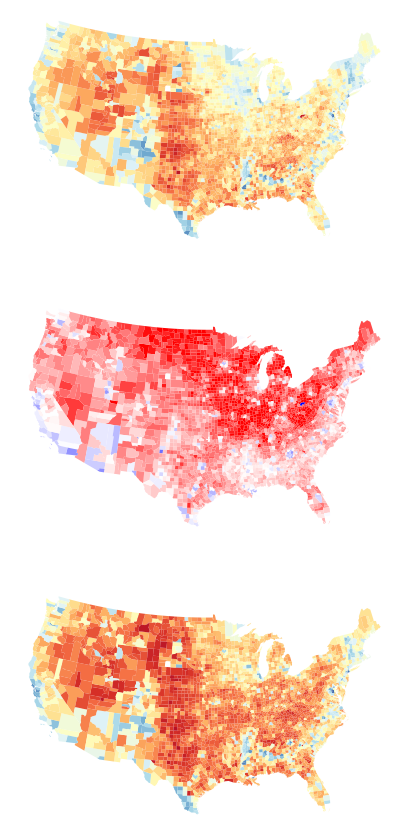

In [10]:
# %load _solved/solutions/case-trump-vote06.py
f,ax = plt.subplots(3,1,
                    subplot_kw=dict(aspect='equal', 
                                    frameon=False),
                    figsize=(60,15))
pres.plot('dem_2008', ax=ax[0], cmap='RdYlBu', vmin=0, vmax=1)
pres.plot('swing_full', ax=ax[1], cmap='bwr_r', vmin=-.2, vmax=.2)
pres.plot('dem_2016', ax=ax[2], cmap='RdYlBu', vmin=0, vmax=1)
for i,ax_ in enumerate(ax):
    ax_.set_xticks([])
    ax_.set_yticks([])

#### Build a spatial weights object to model the spatial relationships between US counties

In [24]:
# %load _solved/solutions/case-trump-vote07.py
import libpysal.api as lp
w = lp.Rook.from_dataframe(pres)

Note that this is just one of many valid solutions. But, all the remaining exercises are predicated on using this weight. If you choose a different weight structure, your results may differ.

#### Is swing "contagious?" Do nearby counties tend to swing together? 

In [25]:
# %load _solved/solutions/case-trump-vote08.py
from pysal import esda as esda
np.random.seed(1)
moran = esda.moran.Moran(pres.swing_full, w)
print(moran.I)


0.6930802468425128


#### Visually show the relationship between places' swing and their surrounding swing, like in a scatterplot. 

Text(0.5,1,'$I = 0.693 \\ \\ (p < 0.001)$')

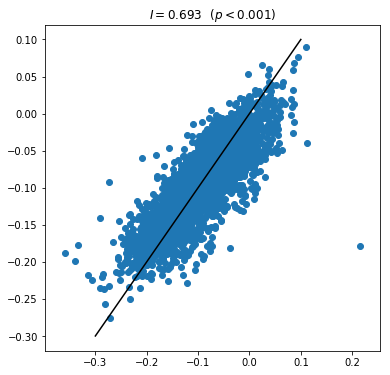

In [26]:
# %load _solved/solutions/case-trump-vote09.py
f = plt.figure(figsize=(6,6))
plt.scatter(pres.swing_full, lp.lag_spatial(w, pres.swing_full))
plt.plot((-.3,.1),(-.3,.1), color='k')
plt.title('$I = {:.3f} \ \ (p < {:.3f})$'.format(moran.I,moran.p_sim))

#### Are there any outliers or clusters in swing using a Local Moran's $I$?

In [27]:
# %load _solved/solutions/case-trump-vote10.py
np.random.seed(11)
lmos = esda.moran.Moran_Local(pres.swing_full, w, 
                              permutations=70000) #min for a bonf. bound
(lmos.p_sim <= (.05/len(pres))).sum()

41

#### Where are these outliers or clusters?

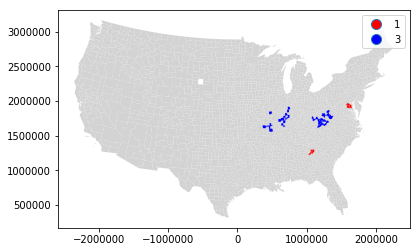

In [28]:
# %load _solved/solutions/case-trump-vote11.py
f = plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_aspect('equal')
is_weird = lmos.p_sim <= (.05/len(pres))
pres.plot(color='lightgrey', ax=ax)
pres.assign(quads=lmos.q)[is_weird].plot('quads', 
                                         legend=True, 
                                         k=4, categorical=True,
                                         cmap='bwr_r', ax=ax)

#### Can you focus in on the regions which are outliers?

(300221.12947796297, 1721965.997477191, 1183473.8523896334, 2010122.0749399317)

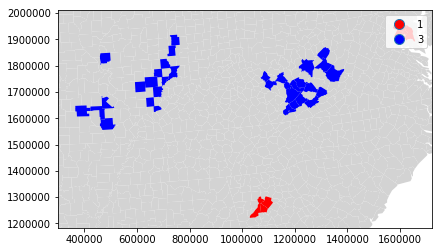

In [29]:
# %load _solved/solutions/case-trump-vote12.py
f = plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_aspect('equal')
is_weird = lmos.p_sim <= (.05/len(pres))
pres.assign(quads=lmos.q)[is_weird].plot('quads', 
                                         legend=True,
                                         k=4, categorical='True',
                                         cmap='bwr_r', ax=ax)
bounds = ax.axis()
pres.plot(color='lightgrey', ax=ax, zorder=-1)
ax.axis(bounds)

Group 3 moves surprisingly strongly from Obama to Trump relative to its surroundings, and group 1 moves strongly from Obama to Hilary relative to its surroundings.

Group 4 moves surprisingly away from Trump while its area moves towards Trump. Group 2 moves surprisingly towards Trump while its area moves towards Hilary. 

#### Relaxing the significance a bit, where do we see significant spatial outliers?

In [30]:
# %load _solved/solutions/case-trump-vote13.py
pres.assign(local_score = lmos.Is, 
            pval = lmos.p_sim,
            quad = lmos.q)\
    .sort_values('local_score')\
    .query('pval < 1e-3 & local_score < 0')[['name','state_name','dem_2008','dem_2016',
                                             'local_score','pval', 'quad']]

,name,state_name,dem_2008,dem_2016,local_score,pval,quad
2700,Washington,Ohio,0.067810,0.282640,-5.992520,0.000229,4
298,Monroe,Indiana,0.662479,0.624804,-1.069071,0.000586,4
441,San Juan,Utah,0.477002,0.355410,-0.432591,0.000843,2
172,Eau Claire,Wisconsin,0.612624,0.539251,-0.329336,0.000386,4
1112,Sangamon,Illinois,0.522164,0.449798,-0.303292,0.000843,4
2746,Monongalia,West Virginia,0.519568,0.443524,-0.299415,0.000343,4
2920,Cabell,West Virginia,0.448643,0.365252,-0.134028,0.000829,4
2648,Tippecanoe,Indiana,0.558866,0.469750,-0.024366,0.000057,4


mainly in ohio, indiana, and west virginia

#### What about when comparing the voting behavior from 2012 to 2016?

In [31]:
# %load _solved/solutions/case-trump-vote14.py
np.random.seed(21)
lmos16 = esda.moran.Moran_Local(pres.swing_2016, w, 
                              permutations=70000) #min for a bonf. bound
(lmos16.p_sim <= (.05/len(pres))).sum()
pres.assign(local_score = lmos16.Is, 
            pval = lmos16.p_sim,
            quad = lmos16.q)\
    .sort_values('local_score')\
    .query('pval < 1e-3 & local_score < 0')[['name','state_name','dem_2008','dem_2016',
                                             'local_score','pval', 'quad']]

,name,state_name,dem_2008,dem_2016,local_score,pval,quad
172,Eau Claire,Wisconsin,0.612624,0.539251,-0.680028,0.000557,4
665,Lake,California,0.599217,0.520347,-0.175233,0.000471,2
58,Carbon,Utah,0.458791,0.248662,-0.158747,0.000400,2
1239,McDonough,Illinois,0.528353,0.437391,-0.153826,0.000014,4
3058,Ohio,West Virginia,0.445533,0.329845,-0.107886,0.000643,4


##### What is the relationship between the Gini coefficient and partisan swing?

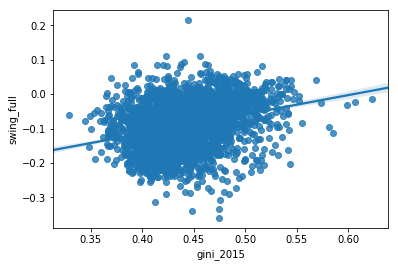

In [32]:
# %load _solved/solutions/case-trump-vote15.py
#% load _solved/solutions/case-trump-vote14.py
sns.regplot(pres.gini_2015,
            pres.swing_full)

Hillary tended to do better than Obama in counties with higher income inequality.
In contrast, Trump fared better in counties with lower income inequality. 
If you're further interested in the sometimes-counterintuitive relationship between income, voting, & geographic context, check out Gelman's [Red State, Blue State](https://www.amazon.com/Red-State-Blue-Rich-Poor/dp/0691143935). 